In [1]:
# %pip install fastapi aiohttp sentence-transformers uvicorn

# FastAPI Dynamic Batching Benchmark

This notebook demonstrates the difference between dynamic batching and no dynamic batching using FastAPI. We'll create two endpoints, one with dynamic batching and one without, then benchmark them by sending requests.

## Step 1: Import Required Libraries

In [2]:
import asyncio
import time
from typing import List, Union
import threading

import aiohttp
from fastapi import FastAPI
from pydantic import BaseModel
from sentence_transformers import SentenceTransformer
import uvicorn

import batched

/home/deepset/miniconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Step 2: Define FastAPI App and Endpoints

In [3]:
app = FastAPI()

# Load the sentence-transformers model
model_dynamic = None
model_no_dynamic = None

class TextInput(BaseModel):
    input: Union[str, List[str]]

class EmbeddingResponse(BaseModel):
    embedding: List[float]

@app.post("/embeddings_dynamic", response_model=EmbeddingResponse)
async def create_embedding_dynamic(input_data: TextInput):
    global model_dynamic
    if model_dynamic is None:
        model_dynamic = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
        model_dynamic.half()
        model_dynamic.encode = batched.aio.dynamically(model_dynamic.encode)
    embedding = await model_dynamic.encode([input_data.input])
    return EmbeddingResponse(embedding=embedding[0].tolist())

@app.post("/embeddings_no_dynamic", response_model=EmbeddingResponse)
async def create_embedding_no_dynamic(input_data: TextInput):
    global model_no_dynamic
    if model_no_dynamic is None:
        model_no_dynamic = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
        model_no_dynamic.half()
        model_no_dynamic.encode = batched.utils.ensure_async(model_no_dynamic.encode)
    embedding = await model_no_dynamic.encode([input_data.input])
    return EmbeddingResponse(embedding=embedding[0].tolist())

## Step 3: Define Server Start Function

In [4]:
def start_server():
    uvicorn.run(app, host="0.0.0.0", port=8000)

## Step 4: Define Benchmark Function

In [5]:
async def benchmark(url: str, num_requests: int):
    async with aiohttp.ClientSession() as session:
        start_time = time.time()
        tasks = []
        for _ in range(num_requests):
            task = asyncio.create_task(
                session.post(url, json={"input": "This is a test sentence."})
            )
            tasks.append(task)
        await asyncio.gather(*tasks)
        end_time = time.time()
    return end_time - start_time

## Step 5: Start the Server in a Separate Thread

In [6]:
server_thread = threading.Thread(target=start_server)
server_thread.start()

time.sleep(5)

# Warm up
await benchmark("http://localhost:8000/embeddings_dynamic", 1)
await benchmark("http://localhost:8000/embeddings_no_dynamic", 1)

time.sleep(5)

INFO:     Started server process [206724]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:54544 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53570 - "POST /embeddings_no_dynamic HTTP/1.1" 200 OK


## Step 6: Run Benchmarks

In [7]:
async def run_benchmarks():
    print("Running benchmarks...")
    num_requests = 1000
    
    dynamic_time = await benchmark("http://localhost:8000/embeddings_dynamic", num_requests)
    print(f"Dynamic batching: {dynamic_time:.2f} seconds for {num_requests} requests")
    
    no_dynamic_time = await benchmark("http://localhost:8000/embeddings_no_dynamic", num_requests)
    print(f"No dynamic batching: {no_dynamic_time:.2f} seconds for {num_requests} requests")
    return dynamic_time, no_dynamic_time

dynamic_time, no_dynamic_time = await run_benchmarks()
print(f"Speedup factor: {no_dynamic_time / dynamic_time:.2f}x")

Running benchmarks...
Dynamic batching: 2.66 seconds for 1000 requests
No dynamic batching: 22.54 seconds for 1000 requests
Speedup factor: 8.46x


INFO:     127.0.0.1:53578 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53582 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53602 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53650 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53714 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:53878 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54170 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54478 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54470 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54468 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54452 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54444 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54434 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO:     127.0.0.1:54430 - "POST /embeddings_dynamic HTTP/1.1" 200 OK
INFO: 

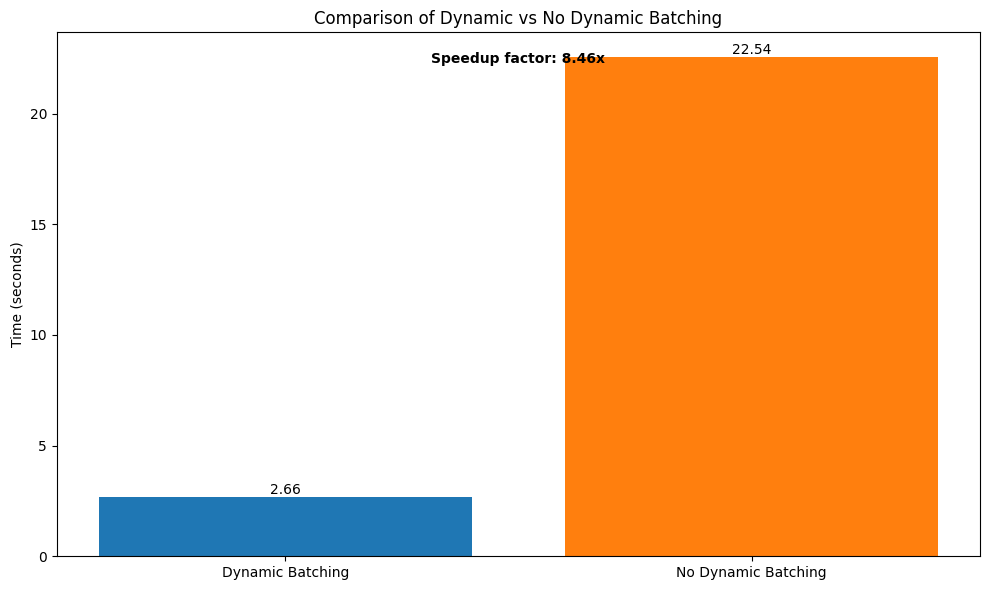

In [8]:
import matplotlib.pyplot as plt

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Dynamic Batching', 'No Dynamic Batching']
times = [dynamic_time, no_dynamic_time]

ax.bar(methods, times, color=['#1f77b4', '#ff7f0e'])

# Customize the plot
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparison of Dynamic vs No Dynamic Batching')

# Add value labels on top of each bar
for i, v in enumerate(times):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Add a text annotation for speedup factor
speedup = no_dynamic_time / dynamic_time
ax.text(0.5, 0.95, f'Speedup factor: {speedup:.2f}x', 
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontweight='bold')

plt.tight_layout()
plt.show()
